# Prompt Chaining
- Chaining multiple prompts together to guide a model through a complex task or reasoning process. 
- Instead of one lrarge prompt, breaks it down into smaller, manageable steps with each step building on the previous one
- This approach can improve accuracy, coherence, and control when working with LLMs
- Langgraph allows you to define a graph of nodes(representing individual prompts or tasks), and edges(representing the flow of information between them)
- We can build a multistep workflow, where the output of one node can feed into the input of next

# Prompt chaining in Langgraph
- Define a task: Start by breaking the problem down into tasks. e.g for a complex report tasks can be: (1.) Gather Data (2.) Analyse Data (3.) Write a summary
- Create Nodes: Each subtask becomes a node. Node could be prompt that instructs model to perform a specific action like 'Summarise text in one paragraph'
- Establish Edges: Edges define sequence and dependencies between nodes. For e.g output of gather data flows into analyse data node, enuring model has necessary context to proceed
- Execute the graph: Langgraph processes nodes in order, passing information along the edges. The model generates responses step by step refining outputs throughout the chain
- Iterate if needed: Langgraph supports conditional logic and loops, so you can revisit earlier nodes or adjust flow based on intermediate results

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model = 'gemma2-9b-it')

result = llm.invoke('Hello')
result

AIMessage(content='Hello! 👋 How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 10, 'total_tokens': 24, 'completion_time': 0.025454545, 'prompt_time': 0.001172219, 'queue_time': 0.102213178, 'total_time': 0.026626764}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--31687af6-2a0a-4353-ad5e-a200bfbd2f28-0', usage_metadata={'input_tokens': 10, 'output_tokens': 14, 'total_tokens': 24})

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#Graph State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str
    
# Nodes
def generate_story(state:State):
    msg = llm.invoke(f'Write a one sentence story premise about {state['topic']}')
    return {'story': msg.content}

def check_conflict(state:State):
    if '?' in state['story'] or '!' in state['story']:
        return 'Fail'
    return 'Pass'

def improved_story(state:State):
    msg = llm.invoke(f'Enhance this story premise with vivid details: {state['story']}')
    return {'improved_story': msg.content}

def polish_story(state:State):
    msg = llm.invoke(f'Add an unexpected twist to this story premise: {state['improved_story']}')
    return {'final_story':msg.content}

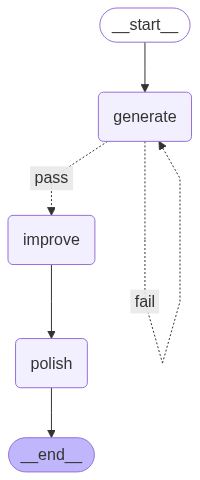

In [ ]:
# Build the graph
graph = StateGraph(State)

## add nodes
graph.add_node('generate', generate_story)
graph.add_node('improve', improved_story)
graph.add_node('polish', polish_story)

## Define edges
graph.add_edge(START, 'generate')
graph.add_conditional_edges('generate', check_conflict, {'Pass':'improve', 'Fail':'generate'})
graph.add_edge('improve', 'polish')
graph.add_edge('polish', END)

# compile graph
compiled_graph = graph.compile()

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [4]:
## Run the graph
state = {'topic': 'World in 2100'}
result = compiled_graph.invoke(state)
result


KeyError: 'Pass'